In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import *

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-07_2224_state_daily_data.csv 2020-04-10_1555_state_rank.csv
2020-04-07_2224_state_rank.csv       2020-04-10_2050_state_daily_data.csv
2020-04-08_2053_state_daily_data.csv 2020-04-10_2050_state_rank.csv
2020-04-08_2053_state_rank.csv       2020-04-11_1640_state_daily_data.csv
2020-04-09_1613_state_daily_data.csv 2020-04-11_1640_state_rank.csv
2020-04-09_1613_state_rank.csv       2020-04-12_0306_state_daily_data.csv
2020-04-10_1539_state_daily_data.csv 2020-04-12_0306_state_rank.csv
2020-04-10_1539_state_rank.csv       2020-04-12_0320_state_daily_data.csv
2020-04-10_1555_state_daily_data.csv 2020-04-12_0320_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-04-12_0320_state_daily_data.csv
	/Users/drskippy/data/2020-04-12_0320_state_rank.csv


In [5]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,tests,posNeg,fips,daily_new_death,hospitalizedIncrease,negativeIncrease,daily_new_positive,totalTestResultsIncrease,order,last_update
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,54,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-04-11
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,NaN,NaN,NaN,...,98,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-04-11
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,125,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-04-11
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,168,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-04-11
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,...,197,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-04-11


### SIR Model

In [6]:
dfq = get_state_df(df, "*")
cc = CurrentCasesUndercount()
dfq = cc.add_positive_estimate(dfq)
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq, params={"a": 220, "shift": 10})
dfq.head()

,date,positive,daily_new_positive,death,daily_new_death,tests,daily_new_positive_undercount,positive_undercount,daily_new_positive_fromdeath,positive_fromdeath
0,2020-02-28,9.0,0.0,4.0,0.0,9,0.0,0,0.0,6820
1,2020-02-29,18.0,9.0,5.0,1.0,18,16.2,16,220.0,7260
2,2020-03-01,31.0,12.0,8.0,3.0,31,21.6,37,660.0,8580
3,2020-03-02,35.0,4.0,11.0,3.0,35,7.2,45,660.0,10340
4,2020-03-03,60.0,25.0,14.0,3.0,66,45.0,90,660.0,11220


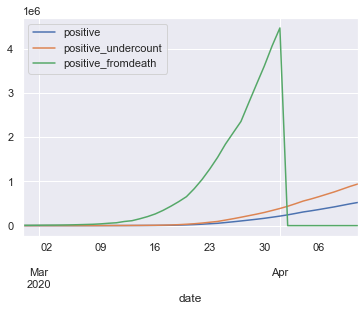

In [7]:
dfq.plot(x="date", y=["positive", "positive_undercount", "positive_fromdeath"])

,day_number,date,positive_predicted,positive,new_daily_positive,hospitalized_ident,icu_ident
43,44,2020-04-11,586677,523199.0,46788.0,49671,13245
44,45,2020-04-12,637520,0.0,50843.0,53975,14393
45,46,2020-04-13,692769,0.0,55249.0,58653,15640
46,47,2020-04-14,752806,0.0,60037.0,63736,16996
47,48,2020-04-15,818046,0.0,65240.0,69260,18469
48,49,2020-04-16,888940,0.0,70894.0,75262,20069
49,50,2020-04-17,965977,0.0,77037.0,81784,21809
50,51,2020-04-18,1049691,0.0,83714.0,88872,23699
51,52,2020-04-19,1140660,0.0,90969.0,96574,25753
52,53,2020-04-20,1239512,0.0,98852.0,104943,27984


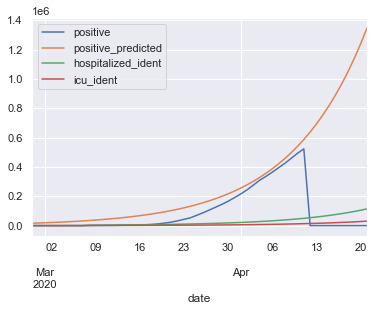

In [8]:
# Exponential Model
mp = ModelProjectionExponential()
d = mp.project(dfq, 10)
d.plot(x="date", y=["positive", "positive_predicted", "hospitalized_ident", "icu_ident"])
d.tail(11)

### SIR Fit

   direc: array([[-2.84270899e-03,  3.72898227e-04,  3.85343536e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-9.99525354e-04,  1.79336932e-04,  1.76448951e-01]])
     fun: 502103.7535279852
 message: 'Optimization terminated successfully.'
    nfev: 269
     nit: 5
  status: 0
 success: True
       x: array([0.26253208, 0.11026296, 3.88997412])
######################################################################
Day 0 = 2020-02-18 00:00:00  (today=43)
Doubling time is about 2.64 days
Recovery time is about 6.29 days
Estimated initial infection was order of 3,889 poeple


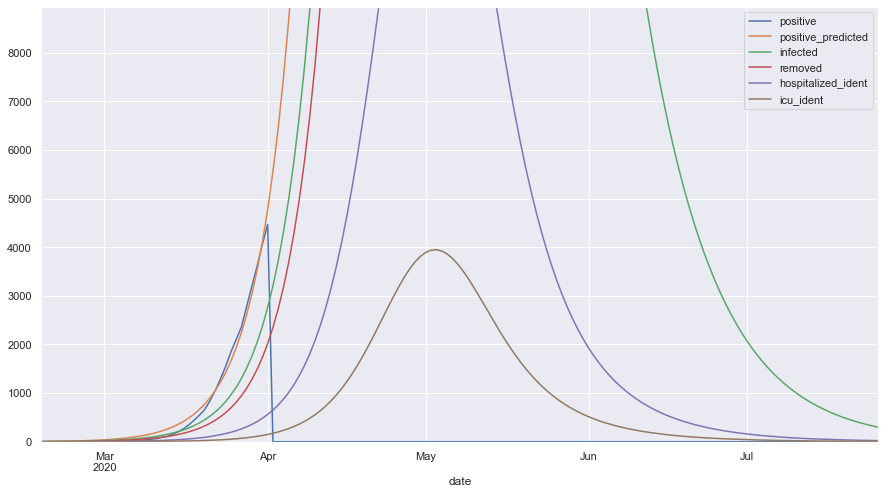

In [9]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

### SIR4: Try Varying beta as part of the model

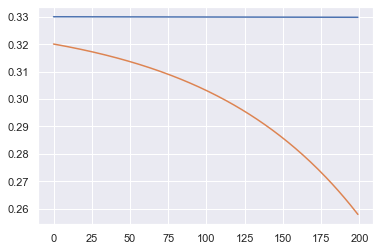

In [10]:
def g(alpha, beta0, t):
    return beta0 - alpha * t

def h(alpha, beta0, t):
    return beta0 - np.log(alpha) * alpha ** t

t = np.arange(0, 200, 1)
plt.plot(t, g(.000001, .33, t))
plt.plot(t, h(1.01, .33, t))
plt.show()

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-1.53118496e-06, -2.06505090e-02, -1.89191465e-02,
         2.24657544e-02],
       [-1.54308373e-05, -4.90083634e-03,  6.48816881e-04,
        -2.27036544e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-5.65033509e-07, -8.72320722e-03, -8.26226343e-03,
         9.58525007e-03]])
     fun: 44452.74053522473
 message: 'Optimization terminated successfully.'
    nfev: 2072
     nit: 35
  status: 0
 success: True
       x: array([1.53767279e-05, 4.25648604e-01, 1.96719580e-01, 3.06435526e-01])
######################################################################
Day 0 = 2020-02-18 00:00:00  (today=43)
Doubling time is about 2.64 days
Recovery time is about 3.52 days
Estimated initial infection was order of 306 poeple


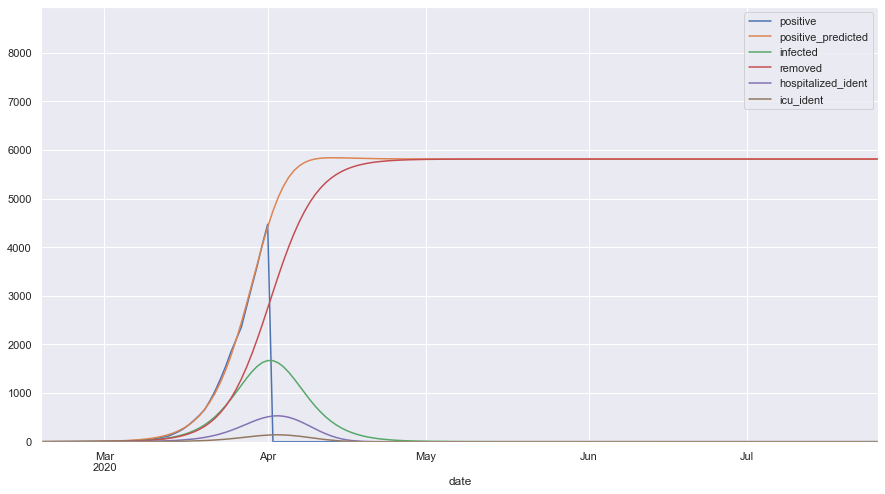

In [11]:
N=350000 
x0 = (0.01313296, 0.87278724, 0.33722395, 0.01900052)  # alpha, beta0, gamma, I0
c = ccd.fit_series/1000
start_date = dfq.date.values[0] - pd.Timedelta(days=ccd.shift)
sf = SIR4()
(N, I0, R0, beta0, alpha, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta0, alpha, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

In [12]:
dfw, wsl = get_dataset_df_from_files()
dfw.head()

,Entity,state,Date,positive,death,daily_new_death,date,last_update,daily_new_positive
0,Afghanistan,AFG,"Dec 31, 2019",0,0,0,2019-12-31,2020-04-12 03:30:35.736216,NaN
1,Afghanistan,AFG,"Jan 1, 2020",0,0,0,2020-01-01,2020-04-12 03:30:35.736216,0.0
2,Afghanistan,AFG,"Jan 2, 2020",0,0,0,2020-01-02,2020-04-12 03:30:35.736216,0.0
3,Afghanistan,AFG,"Jan 3, 2020",0,0,0,2020-01-03,2020-04-12 03:30:35.736216,0.0
4,Afghanistan,AFG,"Jan 4, 2020",0,0,0,2020-01-04,2020-04-12 03:30:35.736216,0.0


   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.21925444e-05, -4.18153897e-08,  7.00053586e-07]])
     fun: 414329.38282809366
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 2
  status: 0
 success: True
       x: array([0.31259992, 0.15240287, 2.6595361 ])
######################################################################
Day 0 = 2020-02-18 00:00:00  (today=102)
Doubling time is about 2.22 days
Recovery time is about 4.55 days
Estimated initial infection was order of 2,659 poeple


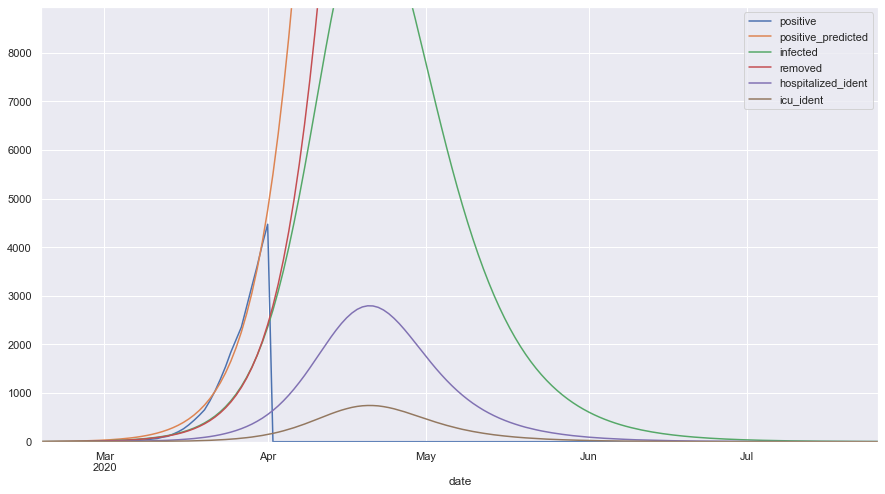

In [13]:
dfq = get_state_df(dfw, "ITA")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=68000 
R0=0
x0 = (0.33821616, 0.15247499, 2.6568561)
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.21925444e-05, -4.18153897e-08,  7.00053586e-07]])
     fun: 414329.38282809366
 message: 'Optimization terminated successfully.'
    nfev: 102
     nit: 2
  status: 0
 success: True
       x: array([0.31259992, 0.15240287, 2.6595361 ])
######################################################################
Day 0 = 2020-02-18 00:00:00  (today=102)
Doubling time is about 2.22 days
Recovery time is about 4.55 days
Estimated initial infection was order of 2,659 poeple


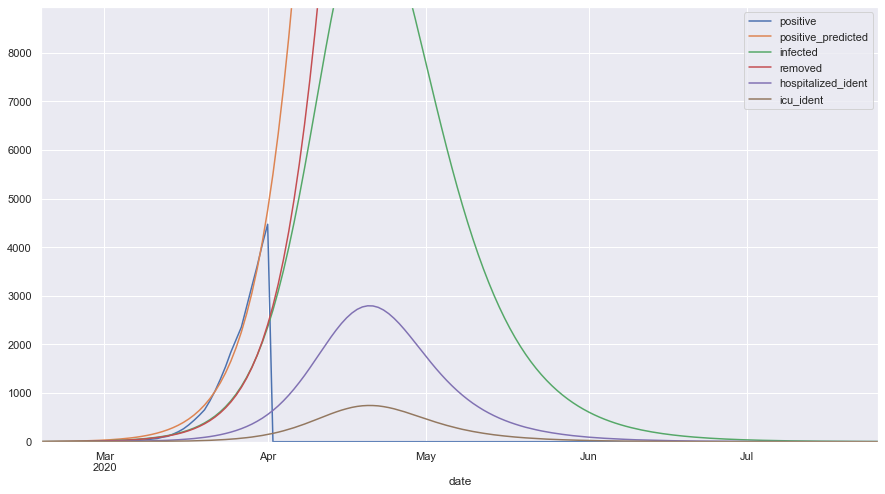

In [14]:
dfq = get_state_df(dfw, "ESP")
ccd = CurrentCasesFromDeaths()
dfq = ccd.add_positive_estimate(dfq)
N=68000 
R0=0
x0 = (0.33821616, 0.15247499, 2.6568561 )
sf = SIR()
(N, I0, R0, beta, gamma) = sf.SIRFitter(c, N, x0)
print("#"*70)
print("Day 0 = {}  (today={})".format(start_date,
                            (pd.Timestamp.now() - dfq.date.values[0]).days + cc.shift))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))
df = sf.project(c, 160, params={"SIR": (N, I0, R0, beta, gamma), "start_date": start_date})
df.plot(x="date", 
        y=["positive", "positive_predicted", "infected", "removed", "hospitalized_ident", "icu_ident"], 
        figsize=[15, 8], ylim=[0, 2*np.max(c)])